# Detection de départ de course de natation

## Algorithme avec 1 bip de référence

### Détection d'un départ

Le fonctionnement de l'algorithme est décrit sur la figure suivante.

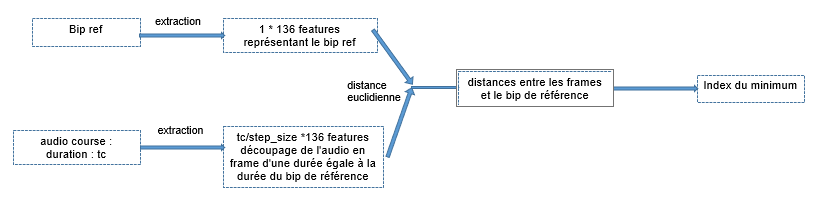

On utilise la librairie pyAudioAnalysis pour le traitement de l'audio

In [50]:
from pyAudioAnalysis import MidTermFeatures as aFm
from pyAudioAnalysis import audioBasicIO as aIO
import moviepy.editor as mp
import numpy as np
import matplotlib.pyplot as plt

La fonction "extract_time_start" renvoie le temps de départ de la course mise en entrée. Elle renvoie également les features de l'extrait audio découpé, les features du bip de référence, ainsi que les distances entre le bip de référence et les différents audio découpés.

In [19]:
def extract_time_start(video_path, bip_ref_path="ref_bip_isolated.wav"):
    
    # features of the ref
    # extract short-term features using a 50msec non-overlapping windows
    fs, s_ref = aIO.read_audio_file(bip_ref_path)
    duration = len(s_ref) / float(fs)
    win, step = 0.05, 0.05
    win_mid, step_mid = duration, 0.5
    mt_ref, st_ref, mt_n_ref = aFm.mid_feature_extraction(s_ref, fs, win_mid * fs, step_mid * fs, win * fs, step * fs)
    
    # extraction on the long signal
    my_clip1 = mp.VideoFileClip(video_path)
    fs = 44100
    s_long = my_clip1.audio.to_soundarray(fps=fs)
    s_long = s_long[:, 0]
    duration_long = len(s_long) / float(fs)

    # extract short-term features using a 50msec non-overlapping windows
    win, step = 0.05, 0.05
    win_mid, step_mid = 0.4, 0.05
    mt_long, st_long, mt_n_long = aFm.mid_feature_extraction(s_long, fs, win_mid * fs, step_mid * fs, win * fs, step * fs)
    
    # normalization for distance calculation
    mt_long = mt_long.T
    for i in range(len(mt_long)):
        mt_long[i] = mt_long[i]/np.linalg.norm(mt_long[i])
    mt_long = mt_long.T
    mt_ref = mt_ref/np.linalg.norm(mt_ref)

    # compute the distance and get the minimum
    distances = np.linalg.norm(mt_long - mt_ref, axis=0)
    arg_min_dist = np.argmin(distances)
    time_start = arg_min_dist * duration_long / mt_long.shape[1]

    return time_start,distances,mt_ref, mt_long.T[arg_min_dist]

In [20]:
video = 'videos/2021_Marseille_brasse_hommes_50_finaleA_fixeDroite.mp4'

In [21]:
start_time = extract_time_start(video)
print("Départ de la course : ",start_time[0],"s")

Départ de la course :  17.31384 s


Graphe des distances :


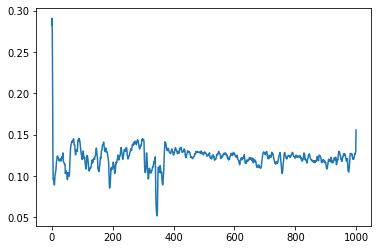

In [62]:
print("Graphe des distances :")
plt.plot(start_time[1])
plt.show()

Graphe des features de référence (en bleu) et des features extraites (en orange) :


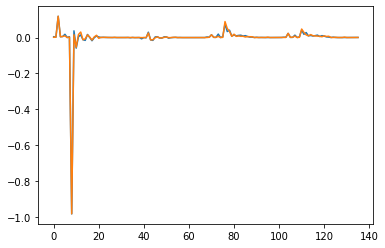

In [61]:
print("Graphe des features de référence (en bleu) et des features extraites (en orange) :")
for i in range(2,4):
    plt.plot(start_time[i])

Ci-dessous le code renvoyant le même résultat mais prennant en entrée un audio (si on a accès uniquement à l'audio d'une vidéo).

In [51]:
def extract_time_start_audio(audio_path, bip_ref_path="ref_bip_isolated.wav"):
    # features of the ref
    # extract short-term features using a 50msec non-overlapping windows
    fs, s_ref = aIO.read_audio_file(bip_ref_path)
    duration = len(s_ref) / float(fs)
    win, step = 0.05, 0.05
    win_mid, step_mid = duration, 0.5
    mt_ref, st_ref, mt_n_ref = aFm.mid_feature_extraction(s_ref, fs, win_mid * fs, step_mid * fs,
                                                          win * fs, step * fs)
    # extraction on the long signal
    fs, s_long = aIO.read_audio_file(audio_path)
    s_long = s_long[:, 0]
    duration_long = len(s_long) / float(fs)

    # extract short-term features using a 50msec non-overlapping windows
    win, step = 0.05, 0.05
    win_mid, step_mid = 0.4, 0.05
    mt_long, st_long, mt_n_long = aFm.mid_feature_extraction(s_long, fs, win_mid * fs, step_mid * fs,
                                                             win * fs, step * fs)
    #normalization
    mt_long = mt_long.T
    for i in range(len(mt_long)):
        mt_long[i] = mt_long[i]/np.linalg.norm(mt_long[i])
    mt_long = mt_long.T
    mt_ref = mt_ref/np.linalg.norm(mt_ref)
    
    # compute the distance and get the minimum
    distances = np.linalg.norm(mt_long - mt_ref, axis=0)
    arg_min_dist = np.argmin(distances)
    time_start = arg_min_dist * duration_long / mt_long.shape[1]
    
    return time_start

In [54]:
audio = 'videos/2021_Marseille_brasse_hommes_50_finaleA_fixeDroite.wav'
start_time_audio = extract_time_start_audio(audio)
print("Départ de la course : ",start_time_audio,"s")

Départ de la course :  17.311775775775775 s


### Détection de plusieurs départs 

La fonction extract_time_start prend en compte l'hypothèse d'un et un seul bip de départ. Les fonctions suivantes s'affranchissent de cette hypothèse. Cepedant elle demande une valeur d'entrée supplémentaire : soit un seuil calculé de manière empirique, soit le nombre de bip à detecter. Cela peut servir pour une longue vidéo où plusieurs courses ont été filmées.

In [37]:
def extract_time_limit(video_path, seuil, bip_ref_path="ref_bip_isolated.wav"):
    # features of the ref
    # extract short-term features using a 50msec non-overlapping windows
    fs, s_ref = aIO.read_audio_file(bip_ref_path)
    duration = len(s_ref) / float(fs)
    win, step = 0.05, 0.05
    win_mid, step_mid = duration, 0.5
    mt_ref, st_ref, mt_n_ref = aFm.mid_feature_extraction(s_ref, fs, win_mid * fs, step_mid * fs,
                                                          win * fs, step * fs)
    # extraction on the long signal
    my_clip1 = mp.VideoFileClip(video_path)
    fs = 44100
    s_long = my_clip1.audio.to_soundarray(fps=fs)
    s_long = s_long[:, 0]
    duration_long = len(s_long) / float(fs)

    # extract short-term features using a 50msec non-overlapping windows
    win, step = 0.05, 0.05
    win_mid, step_mid = 0.4, 0.05
    mt_long, st_long, mt_n_long = aFm.mid_feature_extraction(s_long, fs, win_mid * fs, step_mid * fs,
                                                             win * fs, step * fs)

    # normalization for distance calculation
    mt_long = mt_long.T
    for i in range(len(mt_long)):
        mt_long[i] = mt_long[i]/np.linalg.norm(mt_long[i])
    mt_long = mt_long.T
    mt_ref = mt_ref/np.linalg.norm(mt_ref)    
    

    # compute the distance   
    distances = np.linalg.norm(mt_long - mt_ref, axis=0)
    
    # get the local minimums under the limit
    time_start = []
    for i in range(len(distances)):
        if distances[i] < seuil :
            if distances[i] <= distances[i-1] and distances[i] <= distances[i+1]:
                time_start.append(i * duration_long / mt_long.shape[1])
    
    return time_start

In [24]:
def extract_time_number_of_starts(video_path, number, bip_ref_path="ref_bip_isolated.wav"):
    # features of the ref
    # extract short-term features using a 50msec non-overlapping windows
    fs, s_ref = aIO.read_audio_file(bip_ref_path)
    duration = len(s_ref) / float(fs)
    win, step = 0.05, 0.05
    win_mid, step_mid = duration, 0.5
    mt_ref, st_ref, mt_n_ref = aFm.mid_feature_extraction(s_ref, fs, win_mid * fs, step_mid * fs,
                                                          win * fs, step * fs)
    # extraction on the long signal
    my_clip1 = mp.VideoFileClip(video_path)
    fs = 44100
    s_long = my_clip1.audio.to_soundarray(fps=fs)
    s_long = s_long[:, 0]
    duration_long = len(s_long) / float(fs)

    # extract short-term features using a 50msec non-overlapping windows
    win, step = 0.05, 0.05
    win_mid, step_mid = 0.4, 0.05
    mt_long, st_long, mt_n_long = aFm.mid_feature_extraction(s_long, fs, win_mid * fs, step_mid * fs,
                                                             win * fs, step * fs)
    
    # normalization for distance calculation
    mt_long = mt_long.T
    for i in range(len(mt_long)):
        mt_long[i] = mt_long[i]/np.linalg.norm(mt_long[i])
    mt_long = mt_long.T
    mt_ref = mt_ref/np.linalg.norm(mt_ref)

    # compute the distance
    distances = np.linalg.norm(mt_long - mt_ref, axis=0)
        
    # get all the local minimums and their associated times
    time_start_possible = []
    distances_minimums = []
    for i in range(len(distances)):
        if distances[i] <= distances[i-1] and distances[i] <= distances[i+1]:
            time_start_possible.append(i * duration_long / mt_long.shape[1])
            distances_minimums.append(distances[i])
    
    time_start = []
    
    # extract the smallest local minimums
    for k in range(number):
        arg_min_dist = np.argmin(distances_minimums)
        time_start.append(time_start_possible[arg_min_dist])
        distances_minimums[arg_min_dist] = 1000  
        
    # sort the list in ascending order    
    time_start.sort()

    return time_start

On met en entrée une vidéo qui compile trois courses (et donc trois départs de course).

In [46]:
video2 = 'videos/Compilation.mp4'
number = 3
seuil = 0.08

In [29]:
start_times = extract_time_number_of_starts(video2, number)
for i in range(len(start_times)):
    print("Départ à", start_times[i], "s")

Départ à 7.102594397076735 s
Départ à 29.960943970767353 s
Départ à 60.72218026796589 s


In [49]:
start_times_bis = extract_time_limit(video2, seuil)
for i in range(len(start_times_bis)):
    print("Départ à", start_times_bis[i], "s")

Départ à 7.102594397076735 s
Départ à 29.960943970767353 s
Départ à 60.72218026796589 s


Le calcul du seuil étant purement empirique, la méthode qui demande en entrée le nombre de bip de départ est plus intéressante (il suffit de connaître le nombre de courses qui a lieu dans la vidéo).

## Algorithme avec plusieurs bips de référence

On se replace dans l'hypothèse d'un et un seul bip par vidéo. L'algorithme à un bip de référence renvoie parfois un temps de départ incorrect, dans ce cas il a généralement détecté un bruit "similaire" au bip de départ (géréralement un cri). Pour éviter ces erreurs on mets en entrée de l'algorithme plusieurs bips de référence. On commence par extraire des bips en utilisant la même méthode que précédemment, pour des vidéos où il n'y a pas d'erreur (vérifié au préalable).

In [55]:
def extract_all_features(bip_ref_path="ref_bip_isolated.wav"):
    # features of the ref
    # extract short-term features using a 50msec non-overlapping windows
    fs, s_ref = aIO.read_audio_file(bip_ref_path)
    duration = len(s_ref) / float(fs)
    win, step = 0.05, 0.05
    win_mid, step_mid = duration, 0.5
    mt_ref, st_ref, mt_n_ref = aFm.mid_feature_extraction(s_ref, fs, win_mid * fs, step_mid * fs,
                                                          win * fs, step * fs)
    fs = 44100
    nb_video = 16
    mt_tot = []
    
    # extract features corresponding of a bip (checked before)
    for i in range(nb_video):
        video_path = 'videosChecked/video' + str(i) + '.mp4'
        my_clip1 = mp.VideoFileClip(video_path)
        s_long = my_clip1.audio.to_soundarray(fps=fs)
        s_long = s_long[:, 0]
        win, step = 0.05, 0.05
        win_mid, step_mid = 0.4, 0.05
        mt_long, st_long, mt_n_long = aFm.mid_feature_extraction(s_long, fs, win_mid * fs, step_mid * fs,
                                                             win * fs, step * fs)
        
        distances = np.linalg.norm(mt_long - mt_ref, axis=0)
        arg_min_dist = np.argmin(distances)
        mt_tot.append(mt_long.T[arg_min_dist])
    
    return mt_tot

In [56]:
mt = extract_all_features()

Tous les bips de référence proposent un temps de départ pour la course. Ensuite on élimine les valeurs absurdes en ne conservant que les valeurs autour de la médiane des temps proposés (les valeurs absurdes sont toujours minoritaires). Enfin pour le choix définitif du temps de départ on prend la médiane des temps possibles.

Features des bips extraits :


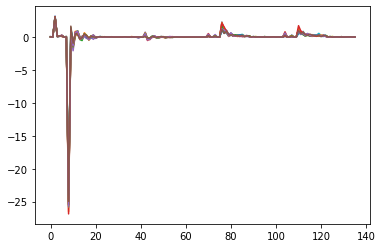

In [59]:
print("Features des bips extraits :")
for i in range(len(mt)):
    plt.plot(mt[i])

In [63]:
def extract_time_allbip(mt, video_path, bip_ref_path="ref_bip_isolated.wav"):
    fs, s_ref = aIO.read_audio_file(bip_ref_path)
    duration = len(s_ref) / float(fs)
    win, step = 0.05, 0.05
    win_mid, step_mid = duration, 0.5

    # extraction on the long signal
    my_clip1 = mp.VideoFileClip(video_path)
    fs = 44100
    s_long = my_clip1.audio.to_soundarray(fps=fs)
    s_long = s_long[:, 0]
    duration_long = len(s_long) / float(fs)

    # extract short-term features using a 50msec non-overlapping windows
    win, step = 0.05, 0.05
    win_mid, step_mid = 0.4, 0.05
    mt_long, st_long, mt_n_long = aFm.mid_feature_extraction(s_long, fs, win_mid * fs, step_mid * fs,
                                                             win * fs, step * fs)
    mt_long = mt_long.T
    
    #normalization
    for i in range(len(mt)):
        for j in range(len(mt[i])):
            mt[i][j] = - mt[i][j] / min(mt[i])
    for i in range(len(mt_long)):
        for j in range(len(mt_long[i])):
            mt_long[i][j] = - mt_long[i][j] / min(mt_long[i])    

    #extract all possible times
    temps_possible = []    
    for i in range(len(mt)):
        arg_min_dist = 0
        min_dist = 1000
        for j in range(len(mt_long)):
            if np.linalg.norm(mt[i]-mt_long[j]) < min_dist :
                arg_min_dist = j
                min_dist = np.linalg.norm(mt[i]-mt_long[j])
        temps_possible.append(arg_min_dist * duration_long / mt_long.shape[0])
    
    #extract non-aberrant times
    median_time = np.median(temps_possible)
    temps_possible_non_aberrant = []
    aberration = 0.5
    for i in range(len(temps_possible)):
        if median_time - aberration <= temps_possible[i]:
            if temps_possible[i] <= median_time + aberration :
                temps_possible_non_aberrant.append(temps_possible[i])
    
    return temps_possible, temps_possible_non_aberrant, np.median(temps_possible_non_aberrant)

In [64]:
start_time_allbip = extract_time_allbip(mt, video)

In [68]:
print("Temps possibles :")
for i in range(len(start_time_allbip[0])):
    print("Départ à", start_time_allbip[0][i], "s")

Temps possibles :
Départ à 17.16372 s
Départ à 17.36388 s
Départ à 18.11448 s
Départ à 17.36388 s
Départ à 17.36388 s
Départ à 17.31384 s
Départ à 17.31384 s
Départ à 17.36388 s
Départ à 17.36388 s
Départ à 18.11448 s
Départ à 9.5076 s
Départ à 17.36388 s
Départ à 17.36388 s
Départ à 17.31384 s
Départ à 17.36388 s
Départ à 17.11368 s


In [69]:
print("Temps possibles non aberrants :")
for i in range(len(start_time_allbip[1])):
    print("Départ à", start_time_allbip[1][i], "s")

Temps possibles non aberrants :
Départ à 17.16372 s
Départ à 17.36388 s
Départ à 17.36388 s
Départ à 17.36388 s
Départ à 17.31384 s
Départ à 17.31384 s
Départ à 17.36388 s
Départ à 17.36388 s
Départ à 17.36388 s
Départ à 17.36388 s
Départ à 17.31384 s
Départ à 17.36388 s
Départ à 17.11368 s


In [70]:
print("Départ à", start_time_allbip[2], "s")

Départ à 17.36388 s
